In [16]:
# -------- Imports ---------
from abc import ABC, abstractmethod
import numpy as np
from typing import Tuple, List, Callable, Optional, Union
from matplotlib import pyplot as plt
from itertools import product
import pandas as pd
from astropy.stats import circmean
from scipy.linalg import inv
from scipy.stats import vonmises
import scipy.stats as st
from astropy.stats import circmean
from filterpy.monte_carlo import systematic_resample
import time
import matplotlib as mpl


In [17]:
# -------- Style with LaTeX and with appropriate font/figure sizes --------

# ----- WARNING SUPPRESSION -----
# This should not be used lightly. This is primarily for formatting reasons for our paper.
import warnings
warnings.filterwarnings('ignore')

DEFAULT_FIGSIZE = (3, 3)
plt.rcParams['figure.figsize'] = DEFAULT_FIGSIZE
plt.rcParams.update({'font.size': 9})

mpl.rcParams["figure.dpi"] = 300

# ---- ENABLE LATEX MATPLOTLIB FONT -----
# Don't run this cell if you have issues with your latex installation
# Use LaTeX fonts
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern Roman"
})

plt.style.use("seaborn-v0_8-muted")

In [18]:
# --------- Define Filter Data types -----------

# Type to represent angles over time. The string is the name of the dataset.
# Angle timeseries are typically 1D arrays, but the filters also support 
# shape (M, N) for M different angle measurements at each of N times.
AngleTimeseries = Tuple[np.ndarray, str] # comment

class AngleFilter(ABC):
    """Represent a filter, which can run on angle timeseries data to get a filtered angle timeseries."""
    
    @abstractmethod
    def run_filter(self, angles: AngleTimeseries) -> AngleTimeseries:
        """Given angles at each timestep, run a filter on the angles and return filters and errors over time.

        Args:
            angle_timeseries (np.ndarray): The angle data over time.

        Returns:
            np.ndarray: The angles.
        """
        pass
        
    @abstractmethod
    def get_name(self, verbose: bool = False) -> str:
        """Get the name, along with details if applicable.

        Args:
            verbose (bool, defaults to False): whether to add extra detail.


        Returns:
            str: the name of this particle filter.
        """
        pass

In [19]:
# -------- Define Helpers for Graphing, Filtering, & Data Cleaning --------

def graph_filter(
    axis: Optional[plt.Axes],
    angle_filter: AngleFilter,
    true_angle: AngleTimeseries,
    noised_angles: AngleTimeseries,
    show_xlabel: bool = False,
    show_ylabel: bool = False,
    linewidth: float = 1
) -> Tuple[float, float]:
    """Graph (or just run) a filter on some angle timeseries data.

    Args:
        axis (Optional[plt.Axes]): the axis on which to render this graph, or None to not graph and just run the filter.
        angle_filter (AngleFilter): The filter to run.
        true_angle (AngleTimeseries): The true angle over time for comparison.
        noised_angles (AngleTimeseries): The angles on which to run the filter, to try and estimate the true angle.
        show_xlabel (bool, optional): If True, show an x label. Defaults to False.
        show_ylabel (bool, optional): If True, show a y label. Defaults to False.
        linewidth (float, optional): Width of lines (and markers). Defaults to 1.

    Returns:
        Tuple[float, float]: total time elapsed, and total average error.
    """
    
    
    if len(true_angle[0].shape)>1:
        true_angle = (true_angle[0][0,:], true_angle[1])
    
    # Time and run the filter
    t0 = time.time()
    filtered_angles_ts = angle_filter.run_filter(noised_angles)
    elapsed = time.time() - t0
    
    # Take the filtered angle data and compute its average error
    filtered_angles, timestamp = filtered_angles_ts
    t = range(len(filtered_angles))
    
    def avg_error(obs: np.ndarray,true: np.ndarray) -> float:
        """
        Computes the average angular error, assuming obs and true are both in radians
        """
        absdiff = np.abs(obs-true)
        cases = np.vstack((absdiff,np.abs(2*np.pi-absdiff)))
        return np.sum(np.min(cases,axis=0))/len(obs)
    
    error = avg_error(filtered_angles, true_angle[0])
    
    # If applicable, graph the filter.
    if axis is not None:
        
        # Precompute the colors to use, so we can graph out of order and get the colors we want.
        filter_color, true_color, noise_color = tuple([next(axis._get_lines.prop_cycler)['color'] for _ in range(3)])
        
        # Graph true angles
        axis.plot(t, np.rad2deg(true_angle[0] % (2*np.pi)), label="True angle (deg)", color=true_color, linewidth=linewidth)
        
        # Only graph noised observations if they're correctly-shaped and different from the true angle.
        if noised_angles[0].shape == true_angle[0].shape and not np.allclose(noised_angles[0], true_angle[0]):
            
            # Graph the noise points
            axis.plot(t, np.rad2deg(noised_angles[0] % (2*np.pi)), ".", label="Observed angle (deg)", color=noise_color, markersize= 2 + linewidth)
        
        # Graph the filtered angles
        axis.plot(t, np.rad2deg(filtered_angles % (2*np.pi)), label="Filtered angle (deg)", color=filter_color, linewidth=linewidth)

        axis.text(0.05, 0.95, f"E={error:.3f}, T={elapsed:.3f}", fontsize=8, transform=axis.transAxes)
        
        axis.set(xlabel=angle_filter.get_name() if show_xlabel else None, ylabel=true_angle[1] if show_ylabel else None)
        
    return elapsed, error


def read_data_csv(fname: str,name: str) -> AngleTimeseries:
    """
    fname is just then name of the csv with angles: ex "pink_90.csv"
    returns AngleTime Series of the first 100 data points
    """
    fname = "Data/" + fname
    data = pd.read_csv(fname,header=None,index_col=None).to_numpy()
    # m,n = data.shape
    data = np.deg2rad(data) + 0.2
    return data[:,:],name

# Angle data can either be just one timeseries (must be transformable into a 1-d array)
# Or two - the true angle (also transformable into 1-d), and the measured / noisy angles (can be 2D.)
AngleDataset = Union[AngleTimeseries, Tuple[AngleTimeseries, AngleTimeseries]]

FilterFactory = Callable[[], AngleFilter]

def graph_filters_on_datasets(
    datasets: List[AngleDataset],
    filters: List[FilterFactory],
    figname: Optional[str] = None,
    linewidth: float = 1
):
    """For each filter, for each dataset, graph the filtered data. Assemble onto large grid.

    Args:
        datasets (List[AngleDataset]): Datasets to graph.
        filters (List[FilterFactory]): Filters to use
        figname (Optional[str], optional): If non-None, use as name to save this figure to. Defaults to None.
        linewidth (float, optional): Size of lines (and markers). Defaults to 1.
    """

    ALL_GRAPH_SCALER = 3

    M, N = len(datasets), len(filters)

    fig, axis_rows = plt.subplots(nrows=M, ncols=N, sharex=True, sharey=True, gridspec_kw={'wspace':0, 'hspace':0},
        squeeze=True, figsize=(ALL_GRAPH_SCALER*N, ALL_GRAPH_SCALER*M))

    # For each combination of filter/dataset, graph.
    for (i, dataset), (j, get_angle_filter) in product(enumerate(datasets), enumerate(filters)):
        
        ax = axis_rows[i][j]
        
        f = get_angle_filter()
        true_angle, observed_angles, true_dataset_name, obs_dataset_name = None, None, None, None
        
        # This checks whether we're dealing with one AngleTimeseries or two.
        if isinstance(dataset[0], tuple):
            true_angle, observed_angles, true_dataset_name, obs_dataset_name = dataset[0], dataset[1], dataset[0][1], dataset[1][1]
        else:
            true_angle, observed_angles, true_dataset_name, obs_dataset_name = dataset, dataset, dataset[1], dataset[1]
            
        # Run and graph.
        print(f"Running {f.get_name()} with true_data={true_dataset_name}, obs. data={obs_dataset_name}")
        graph_filter(
            ax, f, true_angle, observed_angles, 
            show_xlabel = (i == len(datasets) - 1),
            show_ylabel = (j == 0),
            linewidth = linewidth
        )

    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

    # grab unique labels
    unique_labels = set(labels)

    # assign labels and legends in dict
    legend_dict = dict(zip(labels, lines))

    # query dict based on unique labels
    unique_lines = [legend_dict[x] for x in unique_labels]

    # Show legend.
    fig.legend(unique_lines, unique_labels, scatterpoints=1, bbox_to_anchor=(1,1.3), bbox_transform=axis_rows[0][1].transAxes)

    plt.show()
    
    # Save (if applicable) and close.
    if figname is not None:
        fig.savefig(figname, bbox_inches='tight', pad_inches=0)
    plt.close()

In [20]:
# ------- Define a Kalman Filter (Circular and Non-Circular) --------
class KalmanFilter(object):
    def __init__(self,F,Q,u,circular):
        """
        Initialize the dynamical system models.
        
        Parameters
        ----------
        F : ndarray of shape (n,n)
            The state transition model.
        Q : ndarray of shape (n,n)
            The covariance matrix for the state noise.
        u : ndarray of shape (n,)
            The control vector.
        circular: whether to use circular logic or not.
        """
        # inialize everything (except H and R, which are based on the shape of the observations)
        self.F = F
        self.Q = Q
        self.u = u
        self.circular = circular

    def evolve(self, x0, N, H, R, Q):
        """Compute N steps of a Kalman filter using this transition matrix F, 
        but with other parameters as given.

        Args:
            x0: initial state
            N: number of steps
            H: observation matrix
            R: observation covariance
            Q: State covariance

        Returns:
            np.ndarray: (n, m) the M states over N timesteps. 
        """
        
        # set n and m to be useful
        n = len(x0)
        m = len(H)

        # initialize and empty state and obs matrices
        states = np.zeros((n, N))
        obs = np.zeros((m,N))

        # do the first pass
        states[:,0] = x0
        obs[:,0] = (H @ x0 + np.random.multivariate_normal(mean=np.zeros(m), cov=R)) % (2*np.pi)

        for i in range(N-1):
            # iterate 
            states[:,i+1] = (self.F @ states[:,i] + self.u + np.random.multivariate_normal(mean=np.zeros(n), cov=Q)) % (2*np.pi)
            obs[:,i] = (H @ states[:,i] + np.random.multivariate_normal(mean=np.zeros(m), cov=R)) % (2*np.pi)

        # do the last one
        obs[:,-1] = (H @ states[:,-1] + np.random.multivariate_normal(mean=np.zeros(m), cov=R)) % (2*np.pi)

        # return the states and obs
        return states, obs
    

    def estimate(self,x0,P0,z, return_norms = False):
        """
        Compute the state estimates using the kalman filter.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state estimate.
        P0 : ndarray of shape (n,n)
            The initial error covariance matrix.
        z : ndarray of shape(m,N)
            Sequence of N observations (each column is an observation).

        Returns
        -------
        out : ndarray of shape (n,N)
            Sequence of state estimates (each column is an estimate).
        """
        # print(z.shape)
        #Initialize H, R
        theta_dim = z.shape[0]
        H = np.zeros((theta_dim,3))
        H[:,0] = np.ones(theta_dim)
        self.H = H
        self.R = np.eye(theta_dim) * 0.5 
        # get the N, n and initalize an out
        n = len(x0)
        N = z.shape[1]
        out = np.zeros((n, N))

        # set the first value
        out[:,0] = x0

        # iterate 
        for i in range(1,N):
            # we get the temp  by subtracting the observation from the predicted obs
            temp = (z[:,i] - (self.H @ out[:,i-1])) 
            
            # update
            # now yk is either what it is or we shift on the circle no we multiply by the sign to get negatives that are needed
            if self.circular:
                y = []
                for t in temp: # go through all the angles TODO make this nicer
                    if np.abs(t) > np.pi and t < 0: # first we see if the |angle| is bigger than pi and negative then we shift it back 2pi
                        t += 2*np.pi
                    elif np.abs(t) > np.pi and t > 0: # now we see if the angle is positive to shift it forward 2pi
                        t -= 2*np.pi
                    y.append(t)
                # now save it in the array
                yk = np.array(y)
                # yk = np.minimum(np.abs(temp), 2*np.pi - np.abs(temp)) * np.sign(temp)


            else:
                yk = temp
            Sk = self.H @ P0 @ self.H.T + self.R
            Kk = P0 @ self.H.T @ inv(Sk)

            # print(out[:,i-1].shape,Kk.shape,yk.shape) (3,) (3, 1) (1, 100)
            xk = (out[:,i-1] + Kk @ yk)
            Pk = ((np.eye(n) - Kk @ self.H) @ P0).copy()

            # predict
            out[:,i] = (self.F @ xk + self.u) % (2*np.pi)
            P0 = self.F @ Pk @ self.F.T + self.Q
        
        # return out
        return out
    
    def predict(self,x,k):
        """
        Predict the next k states in the absence of observations.

        Parameters
        ----------
        x : ndarray of shape (n,)
            The current state estimate.
        k : integer
            The number of states to predict.

        Returns
        -------
        out : ndarray of shape (n,k)
            The next k predicted states.
        """
        # get the n and initialize and out
        n = len(x)
        out =  np.zeros((n,k))

        # set the first value
        out[:,0] = x
        for i in range(1, k):
            # iterate through 
            out[:,i] = self.F @ out[:,i-1] + self.u

        # return out
        return out
    
    def rewind(self,x,k):
        """
        Predict the states from time 0 through k-1 in the absence of observations.
    
        Parameters
        ----------
        x : ndarray of shape (n,)
            The state estimate at time k.
        k : integer
            The current time step.
    
        Returns
        -------
        out : ndarray of shape (n,k)
            The predicted states from time 0 up through k-1 (in that order).
        """
        # get the n and make an empty out
        n = len(x)
        out =  np.zeros((n,k))

        # do the last one
        out[:,-1] = x

        # save F inverse so we don't compute it everytime
        F_inv = inv(self.F)
        for i in range(1, k):
            # iterate backwards
            out[:,-i-1] = F_inv @ (out[:,-i] - self.u)

        # return out
        return out
                
    def get_name(self, verbose: bool = False) -> str:
        return (
            f"{'Circular' if self.circular else 'Noncircular'} KF"
        )
        
    def run_filter(self, angles_ts: AngleTimeseries) -> AngleTimeseries:
        angles, _ = angles_ts
        if len(angles.shape)==1:
            angles = np.expand_dims(angles,0)
        return self.estimate(np.array([np.pi, np.pi, 0]), np.eye(3)*0.001, angles)[0], "Filtered KF angles"
    


In [21]:
# -------- Define Particle Filter -----------

class ParticleFilter(AngleFilter):    
    def __init__(self,F,K1,K2,N_particles,n_eff_needed=20):
        """
        Initialize the dynamical system models.
        
        Parameters
        ----------
        F : ndarray of shape (n,n)
            The state transition model.
        K1 : float
            the "circular variance" of the system's noise. Kappa 1.
        K2 : ndarray of shape (m,m)
            The "circular variance" for observation noise. Kappa 2.
        """

        # inialize everything
        self.K1 = K1
        self.K2 = K2
        self.F=F
        self.n_eff_needed=n_eff_needed
        
        # We initialize our particles as 0 angular velocity, uniformly distributed angles on [0,2π]
        self.N_particles = N_particles
        self.particles = np.zeros((N_particles,F.shape[0]))
        self.particles[:,0] = np.random.uniform(0,2*np.pi,N_particles)
        self.particles[:,1] = self.particles[:,0]
        
        # We initialize the particles weights to all be equal:
        self.weights = 1/N_particles*np.ones(N_particles)
        
    def creat_uniform_particles(N):
        """
        returns uniformly distributed particles and their weights
        """
        return np.random.uniform(0,2*np.pi,N),1./N * np.ones(N)
    
    def get_name(self,verbose=False):
        if verbose:
            return f"Particle F., K1={self.K1},K2={self.K2},N_particles = {self.N_particles}"
        else:
            return 'Particle F.'
        
    def create_von_mises_particles(self,loc,kappa,N):
        """
        returns von mises distributed particles and their weights
        """
        particles = vonmises(loc=loc, kappa=kappa).rvs(N)
        # weights = vonmises(loc=loc, kappa=kappa).pdf(particles)
        return particles#,weights
    
    def predict_particles(self,particles):
        #predicts the next state of the particles, adding noise into the prediction as well
        #I'm really not sure what kappa variable to use for our noise on both ends
        noise = np.zeros_like(particles)
        # noise_new_state = self.create_von_mises_particles(loc=0,kappa=self.K1,N=self.N_particles)
        noise[:,0] = vonmises(loc=0, kappa=self.K1).rvs(self.N_particles)
        #I feel like we don't want noise in our angular velocity estimate or our previous state that we just want to keep track of
        # print(noise_new_state)
        new_particles= (particles@(self.F.T) + noise)%(2*np.pi) #want to do (F@particles.T).T including noise,Make sure it's in the range of 0,2pi
        return new_particles
    
    def update_particles(self,particles,weights,obs):
        """
        obs: (n_obs,) ndarray of observations


        Updates the particle weights using Bayesian Posterior probability.
        P(particle|data) = P(particle)*P(data|particle)
        => new_weight = old_weight * von_mises(data|mean=particle,kappa=K2)
        The "Prior" is just the weight from the previous step.
        The "Likelihood" is just the probability of the data from von mises with mean centered at the particle

        We only calculate the weights based on the current angle estimate, ignoring states 2 and 3

        Returns:
            new_weights: array like weights
        """

        tot_likelihood = np.array([vonmises(loc=particles[:,0],kappa=self.K2).pdf(ang) for ang in obs]).mean(axis=0) #Vectorizing the particles part and looping over the angle measurement speeds it up 7x

        #Get the posterior weights
        new_weights = weights*tot_likelihood
        new_weights += 1.e-300 #literally no idea why the original author did this
        #rescale to make them sum to 1 so they're a probability distribution
        new_weights = new_weights/np.sum(new_weights)
        return new_weights

    def state_estimate_from_particles(self,particles,weights):
        #Computes the WEIGHTED circular mean of the particles (just the current angle)
        return circmean(particles[:,0],weights=weights)#%(2*np.pi)

    def resample(self,particles,weights):
        """
        Re-sample from our current particles, using filterpy to do so
        
        Returns:
            particles_chosen
            updated_weights
        """
        particles_chosen = systematic_resample(weights)
        updated_weights = np.ones_like(weights)/self.N_particles
        return particles[particles_chosen,:],updated_weights
    
    def neff(self,weights):
        #This is the "effective" number of particles. If this falls below a threshold, we need to resample
        return 1. / np.sum(np.square(weights))

    def run_filter_verbose(self,obs):
        """
        Performs the particle filter routine for the entire dataset
        Returns a sequence of state estimates for each time step, as well as particles and effective number of particles
        """
        theta_dim = obs.shape[0]
        H = np.zeros((theta_dim,3))
        H[:,0] = np.ones(theta_dim)
        self.H = H
        n_eff_list = np.zeros(obs.shape[1])
        tot_particles = np.zeros((obs.shape[1],self.particles.shape[0],self.particles.shape[1]))
        state_estimates = np.zeros(obs.shape[1])
        for i in range(obs.shape[1]):
            tot_particles[i] = self.particles
            #start by updating the weights of the particles
            current_obs = obs[:,i]
            self.weights = self.update_particles(self.particles,self.weights,current_obs)
            
            #Every so often, we want to resample:
            n_eff_list[i] = self.neff(self.weights)
            if self.neff(self.weights) <= self.n_eff_needed:#.1*self.N_particles:
                # print('resampling successful',self.neff(self.weights))
                self.particles,self.weights = self.resample(self.particles,self.weights)
            #Every so often, we want to resample:
            # if i+1%5==0:#.1*self.N_particles:
            #     # print('resampling successful',self.neff(self.weights))
            #     self.particles,self.weights = self.resample(self.particles,self.weights)
            
            #Compute our state estimate
            state_estimates[i] = self.state_estimate_from_particles(self.particles,self.weights)

            #Predict the next state of the particles
            self.particles = self.predict_particles(self.particles)
        return state_estimates,tot_particles,n_eff_list
    
    def run_filter(self,angles_ts: AngleTimeseries):
        """
        Performs the particle filter routine for the entire dataset
        Returns a sequence of state estimates for each time step
        For use in the abstract class
        """
        #make a (,n) array be (1,n)
        # obs = np.array([angles_ts[0]])
        obs = angles_ts[0]
        if len(obs.shape)==1:
            obs = np.expand_dims(obs,0)
        #initialize H
        theta_dim = obs.shape[0]
        H = np.zeros((theta_dim,3))
        H[:,0] = np.ones(theta_dim)
        self.H = H
        
        state_estimates = np.zeros(obs.shape[1])
        for i in range(obs.shape[1]):
            #start by updating the weights of the particles
            current_obs = obs[:,i]
            self.weights = self.update_particles(self.particles,self.weights,current_obs)
            #Resample whenever we don't have enough effective particles
            if self.neff(self.weights) <= self.n_eff_needed:
                self.particles,self.weights = self.resample(self.particles,self.weights)
            #Compute our state estimate
            state_estimates[i] = self.state_estimate_from_particles(self.particles,self.weights)
            #Predict the next state of the particles
            self.particles = self.predict_particles(self.particles)
        return state_estimates, "Filtered Particle"
    
    def run_filter_timing(self,obs):
        """
        Performs the particle filter routine for the entire dataset
        Returns a sequence of state estimates for each time step
        For use in the abstract class
        """
        state_estimates = np.zeros(obs.shape[1])
        tot_times = []
        for i in range(obs.shape[1]):
            #start by updating the weights of the particles
            current_obs = obs[:,i]
            time1 = time()
            self.weights = self.update_particles(self.particles,self.weights,current_obs)
            time2 = time()
            #Resample whenever we don't have enough effective particles
            if self.neff(self.weights) <= self.n_eff_needed:
                self.particles,self.weights = self.resample(self.particles,self.weights)
            time3 = time()
            #Compute our state estimate
            state_estimates[i] = self.state_estimate_from_particles(self.particles,self.weights)
            time4 = time()
            #Predict the next state of the particles
            self.particles = self.predict_particles(self.particles)
            time5 = time()
            tot_times.append([time2-time1,time3-time2,time4-time3,time5-time4])
        return state_estimates,tot_times

In [22]:
# ------ Instantiate our Various Filters --------
deltat = 512./48000
F = np.array([[1,0,deltat],
        [1,0,0],
        [deltat**-1, deltat**-1, 0]])
#data is just one dimensional theta values
theta_dim = 1
# H = np.zeros((theta_dim,3))
# H[:,0] = np.ones(theta_dim)
u = np.zeros(3) #No control
Q = np.eye(3) * 0.001

filter_factories = [
    # lambda : LeakyFilter(4),
    lambda : KalmanFilter(F, Q, u, False),
    lambda : KalmanFilter(F, Q, u, True),
    lambda : ParticleFilter(F, 1, 1, 500, 25)
]


Running Noncircular KF with true_data=Wraparound, obs. data=Noisy
Running Circular KF with true_data=Wraparound, obs. data=Noisy
Running Particle F. with true_data=Wraparound, obs. data=Noisy
Running Noncircular KF with true_data=With Jump, obs. data=Noisy
Running Circular KF with true_data=With Jump, obs. data=Noisy
Running Particle F. with true_data=With Jump, obs. data=Noisy
Running Noncircular KF with true_data=Switching, obs. data=Noisy
Running Circular KF with true_data=Switching, obs. data=Noisy
Running Particle F. with true_data=Switching, obs. data=Noisy


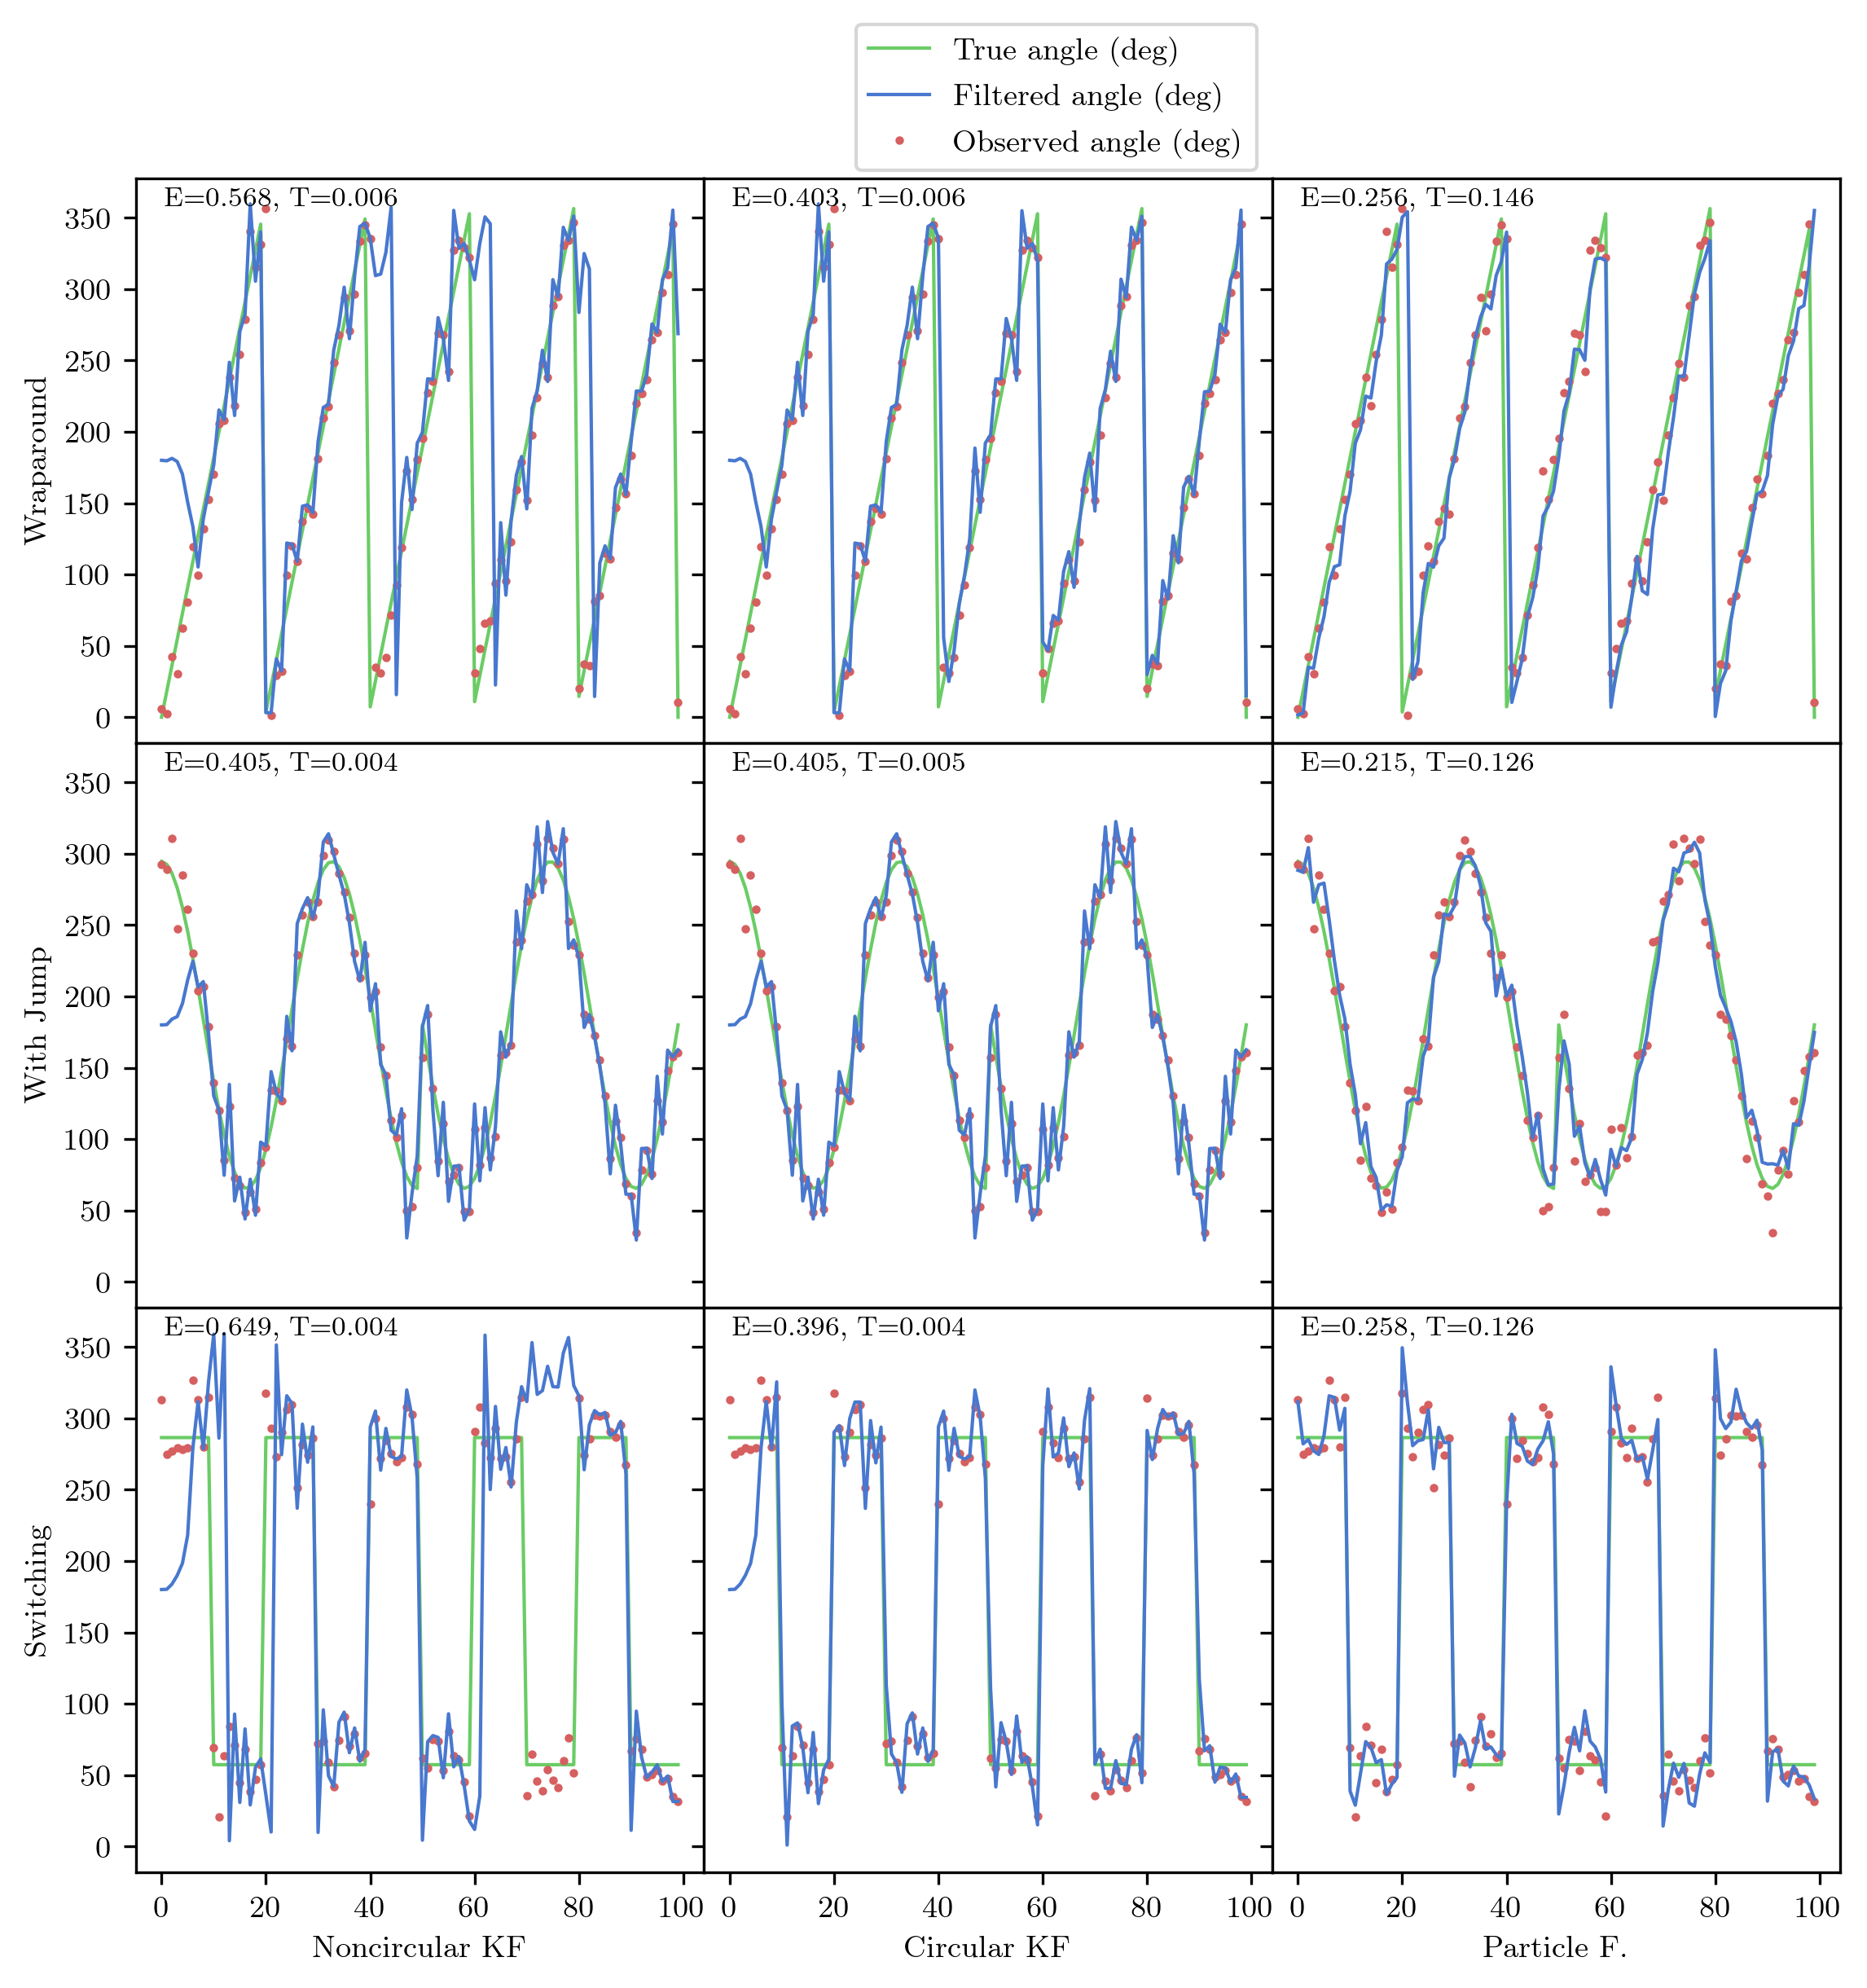

In [23]:
# ------- Graph on simulated data ----------

simulated_data = [
    (np.linspace(0, 10*np.pi, 100) % (2*np.pi), "Wraparound"),
    (np.concatenate([np.pi + 2*np.cos(np.linspace(0, 3*np.pi, 50)), np.pi + 2*np.sin(np.linspace(3*np.pi, 6*np.pi, 50))]) % (2*np.pi), "With Jump"),
    (np.where((np.array(list(range(100)), dtype=int) // 10) % 2 == 0, 5*np.ones((100,)), 1*np.ones((100,))), "Switching"),
]

NOISE_SIGMA_SQ = 0.3
noised_angles = [((st.norm.rvs(sd[0], NOISE_SIGMA_SQ*np.ones_like(sd[0]), len(sd[0]))) % (2*np.pi), "Noisy") for sd in simulated_data]

simulated_data_with_noise = [(a, b) for (a, b) in zip(simulated_data, noised_angles)]

graph_filters_on_datasets(simulated_data_with_noise, filter_factories, figname="actual_paper_graphs/all_simulated.pdf")

Running Noncircular KF with true_data=speech_moving One_Angle, obs. data=speech_moving One_Angle
Running Circular KF with true_data=speech_moving One_Angle, obs. data=speech_moving One_Angle
Running Particle F. with true_data=speech_moving One_Angle, obs. data=speech_moving One_Angle
Running Noncircular KF with true_data=pinknoise_moving One_Angle, obs. data=pinknoise_moving One_Angle
Running Circular KF with true_data=pinknoise_moving One_Angle, obs. data=pinknoise_moving One_Angle
Running Particle F. with true_data=pinknoise_moving One_Angle, obs. data=pinknoise_moving One_Angle


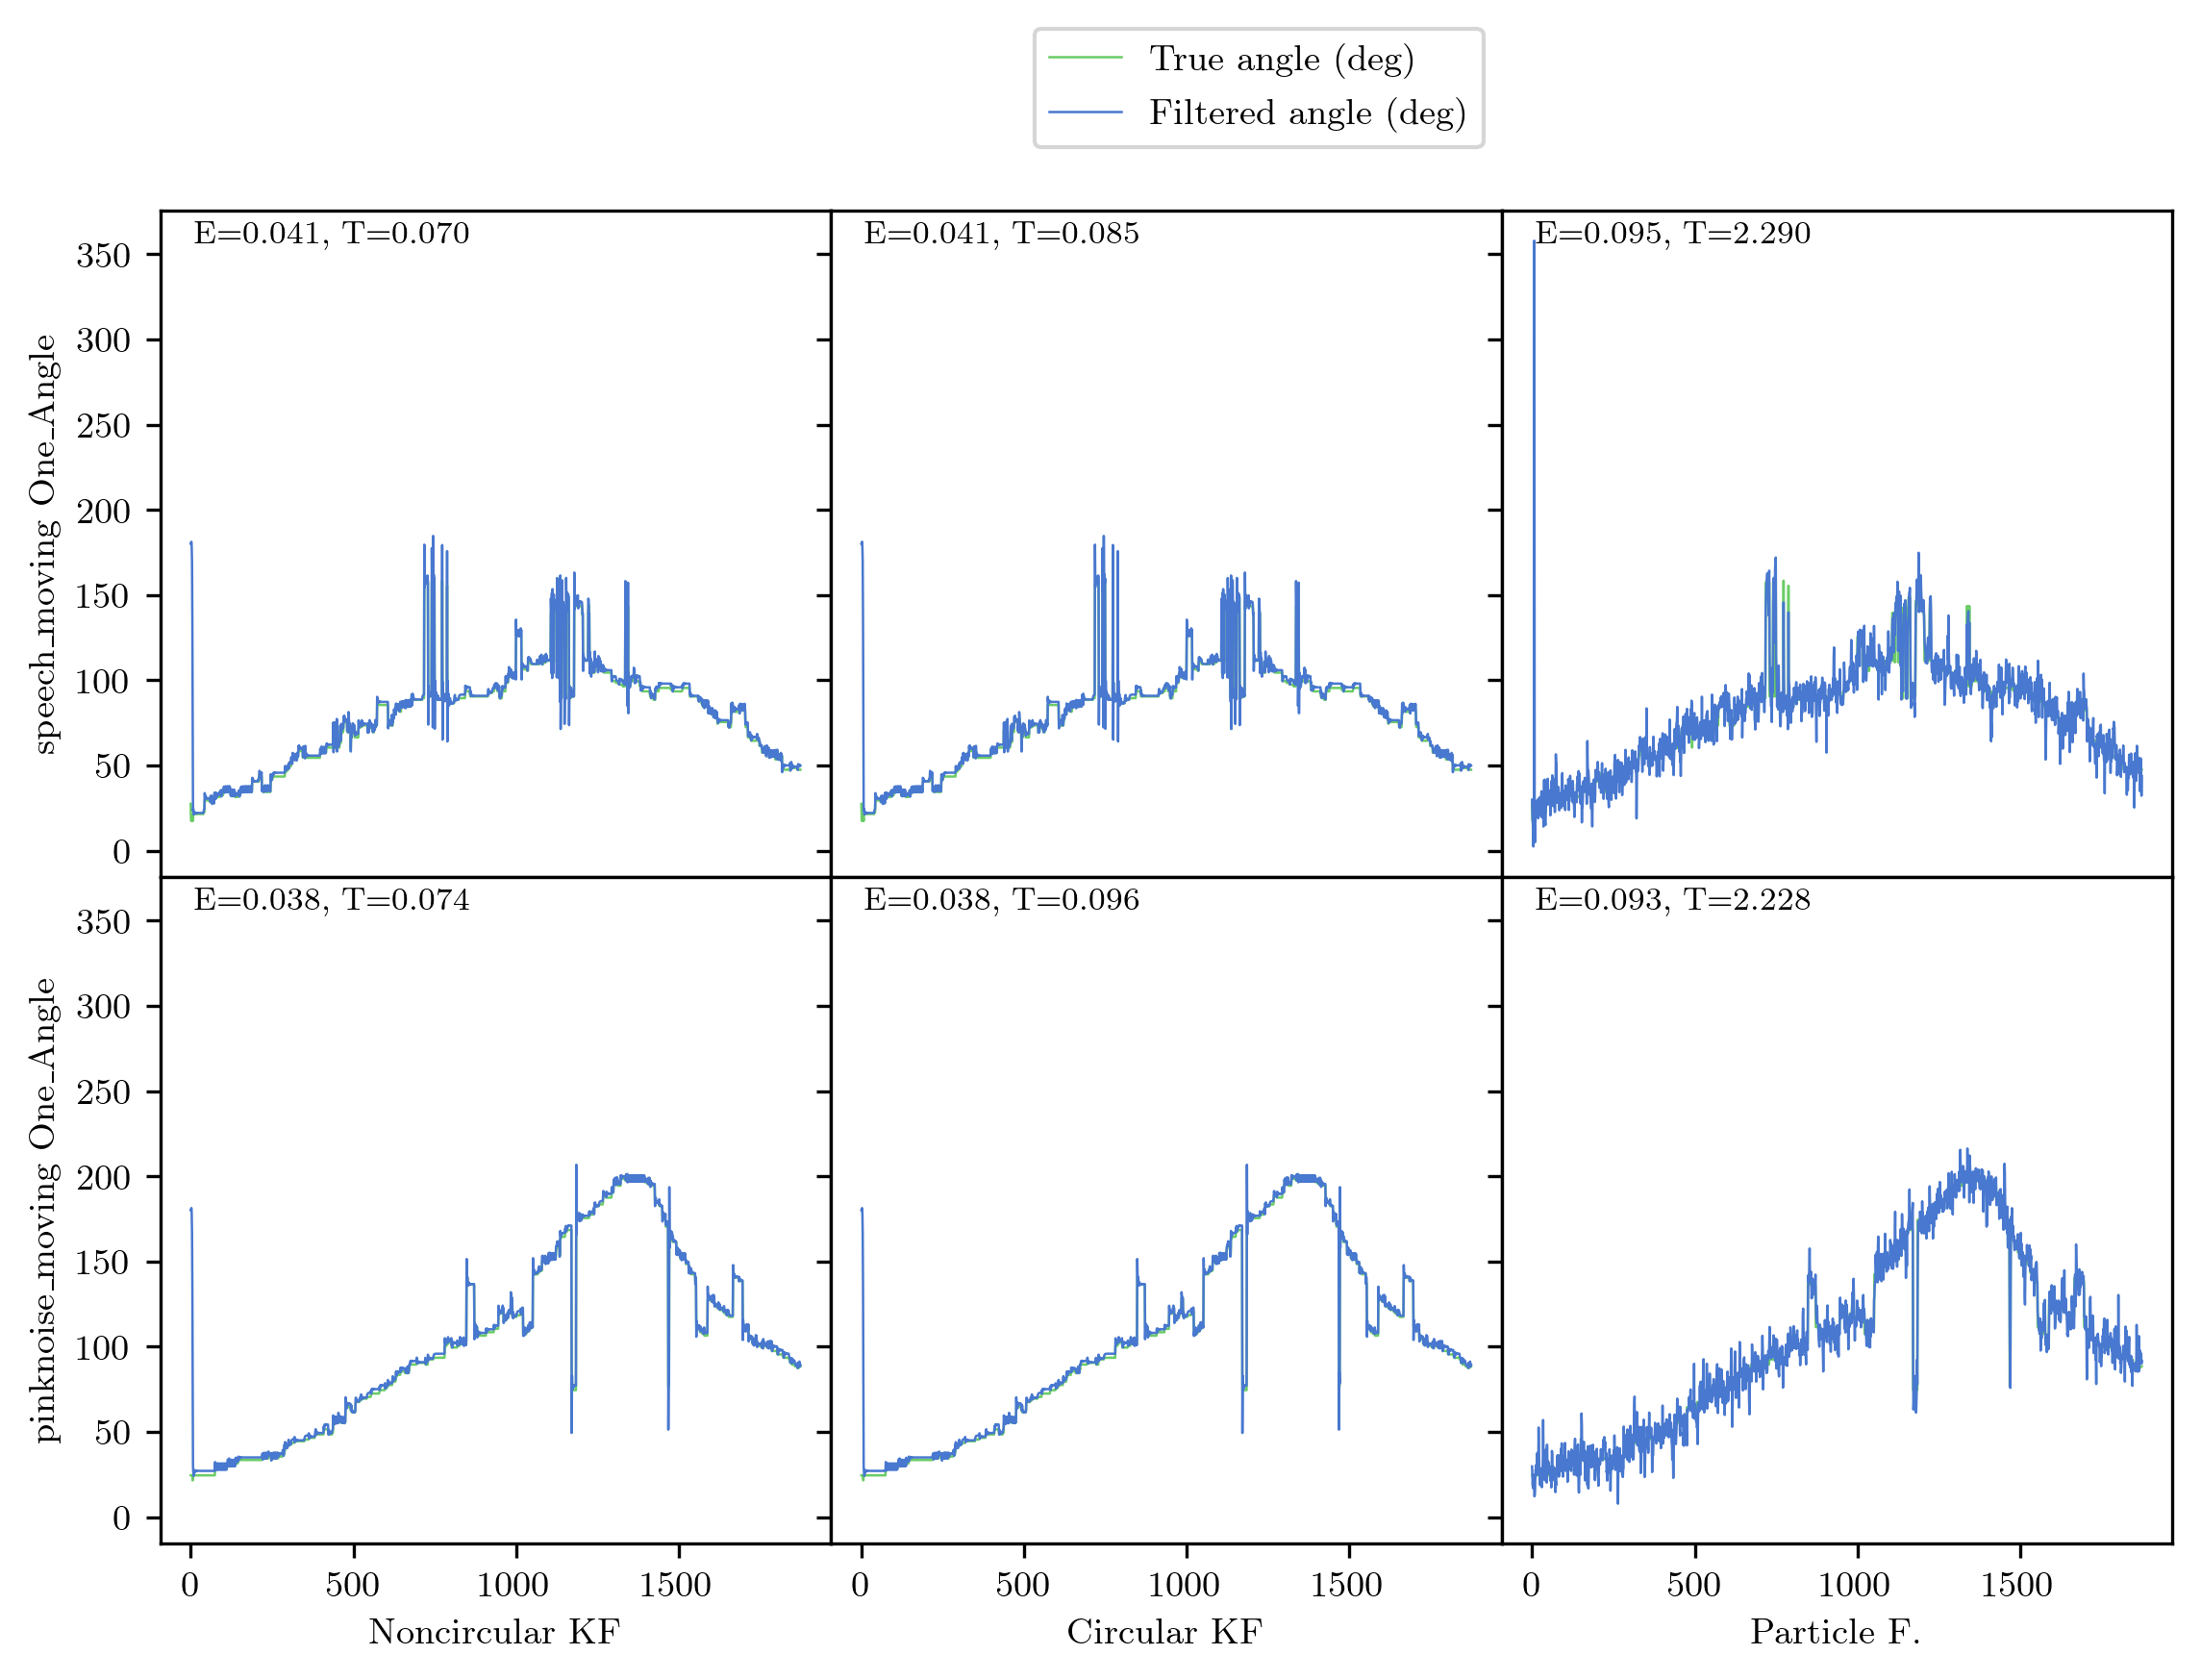

In [24]:
# -------- Graph on Real Data --------

# define fnames and data of the new measurements
file_names_real_data = [
    # 'speech_0',
    # 'speech_90',
    'speech_moving',
    'pinknoise_moving',
    # 'pinknoise_90',
    # 'pinknoise_0'
]
scenarios = [
    # 'All_Angles',
    'One_Angle'
]
real_data = [read_data_csv(f"{fname}_{scenario}.csv", f"{fname} {scenario}") for fname in file_names_real_data for scenario in scenarios]

graph_filters_on_datasets(real_data, filter_factories, linewidth=0.6, figname="actual_paper_graphs/all_real.pdf")

Running Noncircular KF with true_data=speech_moving true angle, obs. data=speech_moving all angles
Running Circular KF with true_data=speech_moving true angle, obs. data=speech_moving all angles
Running Particle F. with true_data=speech_moving true angle, obs. data=speech_moving all angles
Running Noncircular KF with true_data=pinknoise_moving true angle, obs. data=pinknoise_moving all angles
Running Circular KF with true_data=pinknoise_moving true angle, obs. data=pinknoise_moving all angles
Running Particle F. with true_data=pinknoise_moving true angle, obs. data=pinknoise_moving all angles


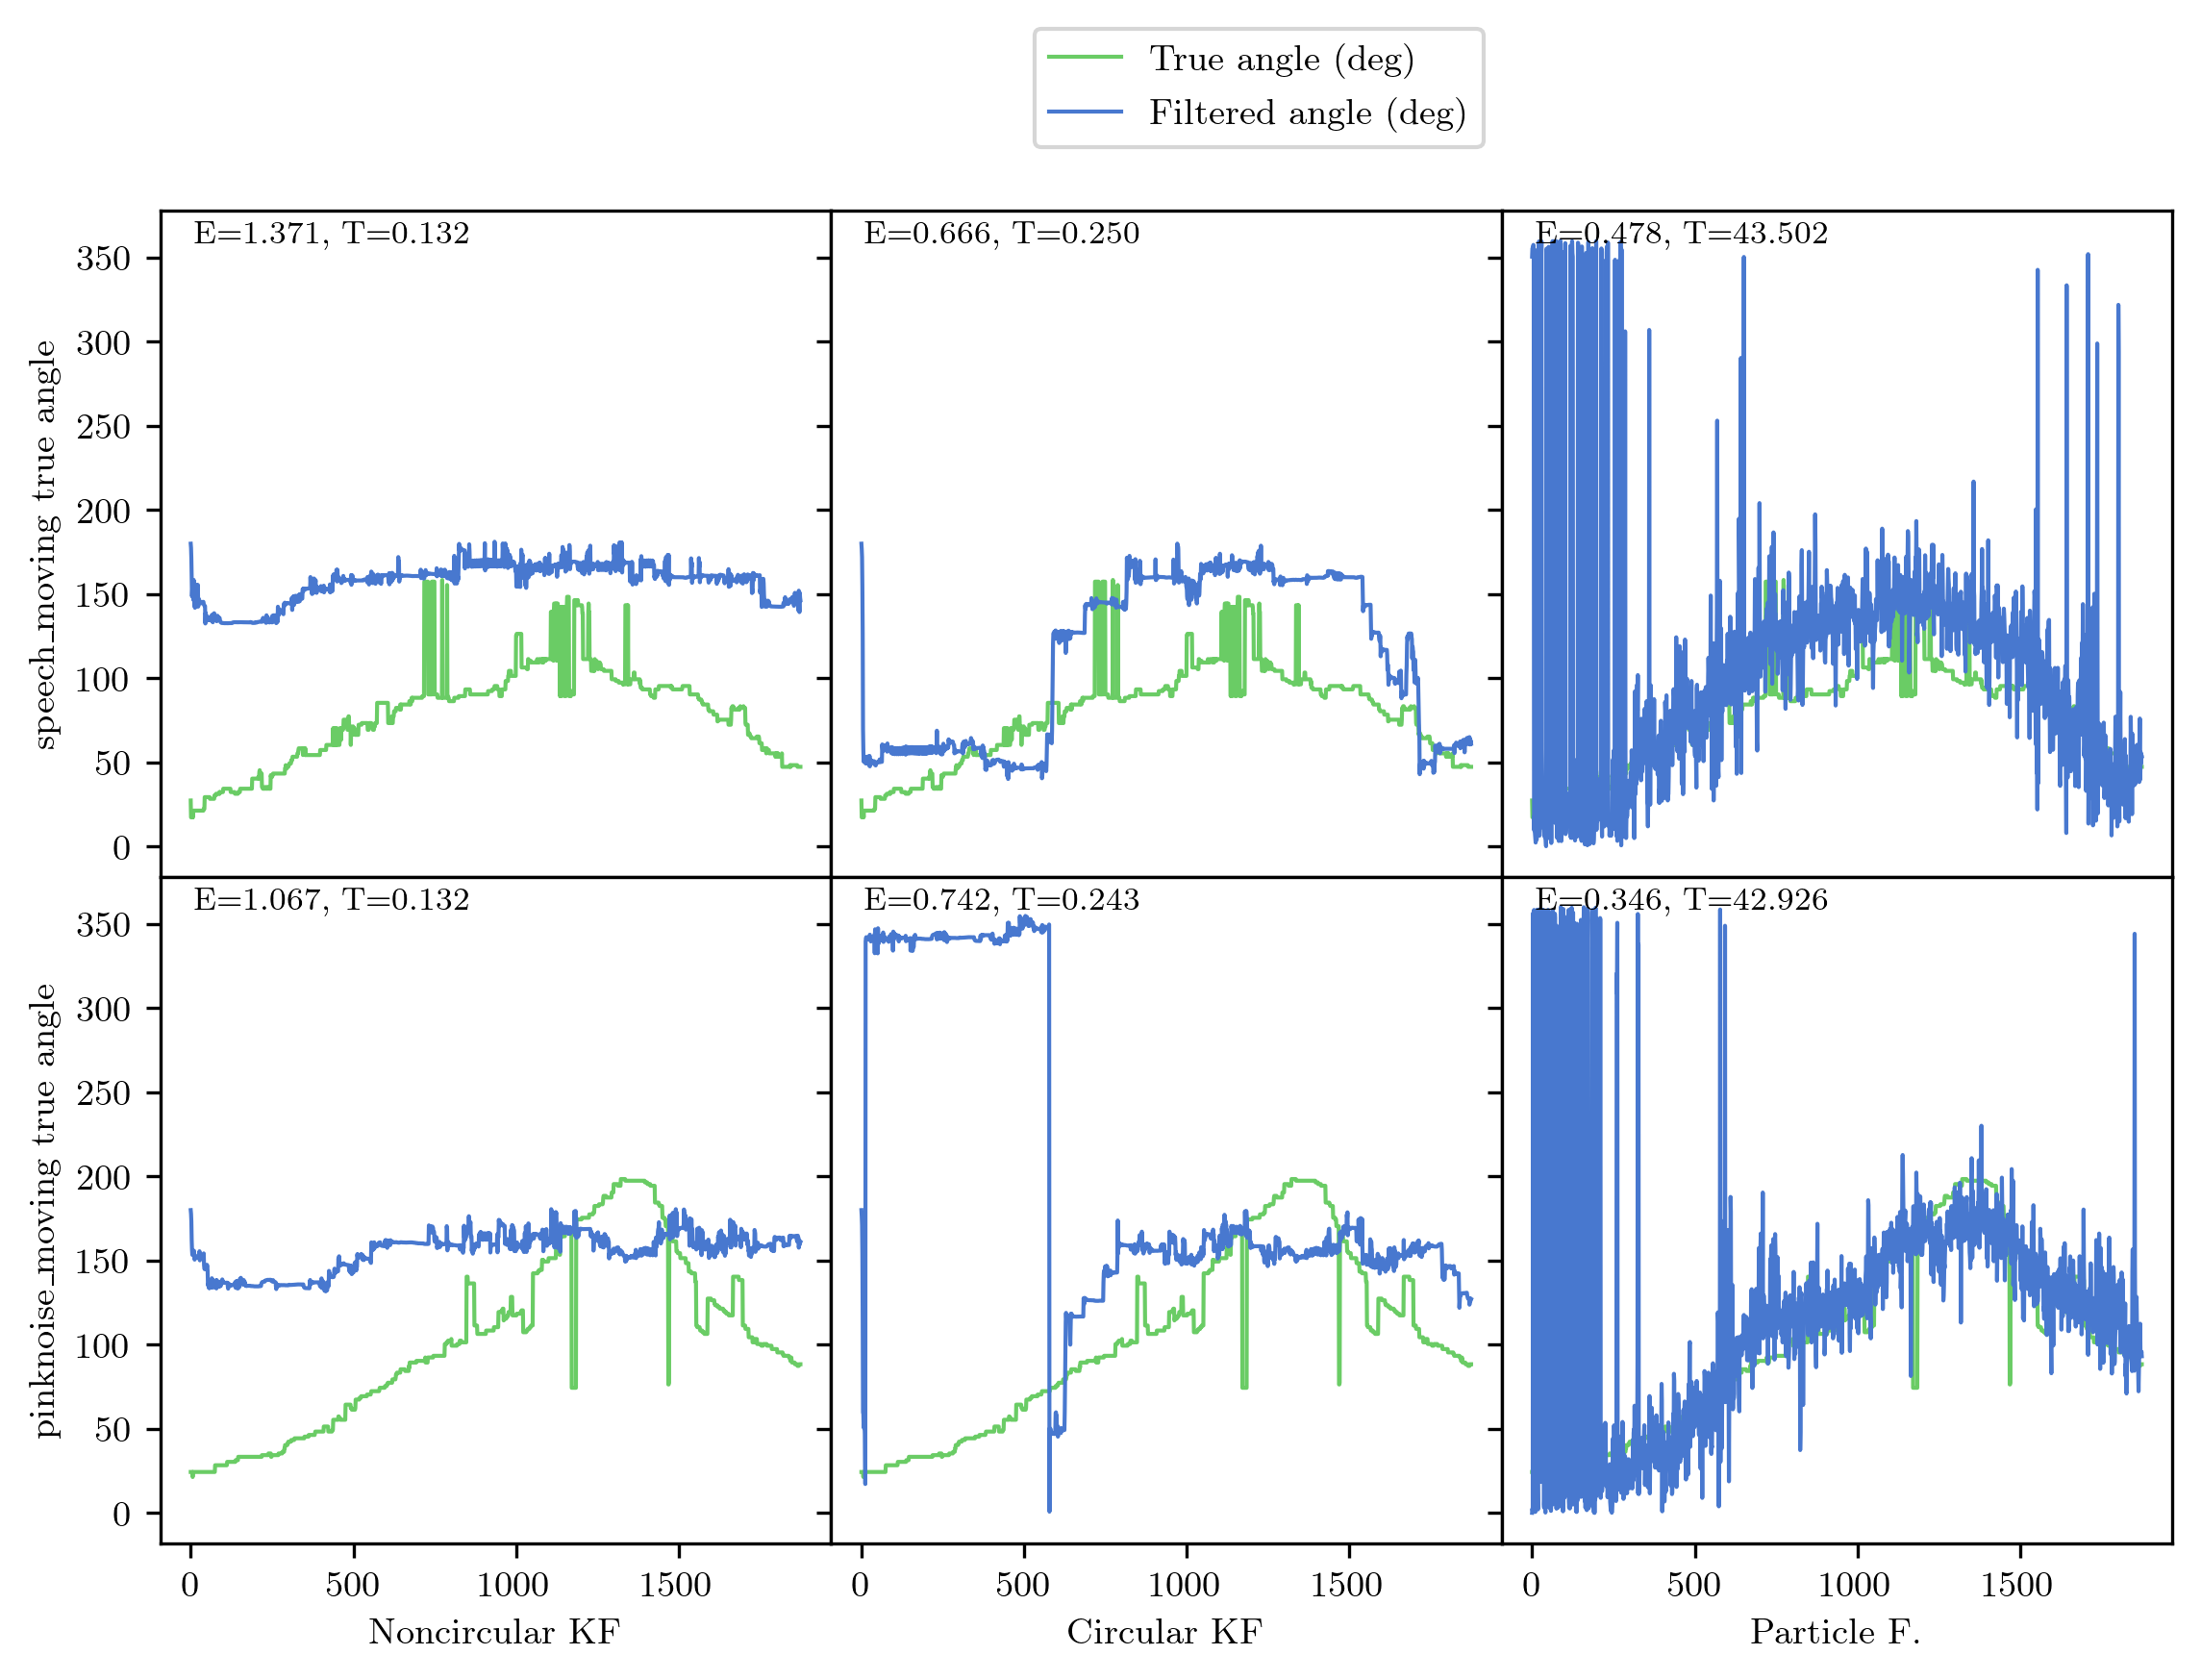

In [25]:
# --------- Graph with multiple angles on real data. ---------

file_names_all_angles = [
    # 'speech_0',
    # 'speech_90',
    'speech_moving',
    'pinknoise_moving',
    # 'pinknoise_90',
    # 'pinknoise_0'
]
all_angles_data = [(read_data_csv(f"{fname}_One_Angle.csv", f"{fname} true angle"), read_data_csv(f"{fname}_All_Angles.csv", f"{fname} all angles")) for fname in file_names_all_angles]
graph_filters_on_datasets(all_angles_data, filter_factories, figname="actual_paper_graphs/multiple_angles.pdf")

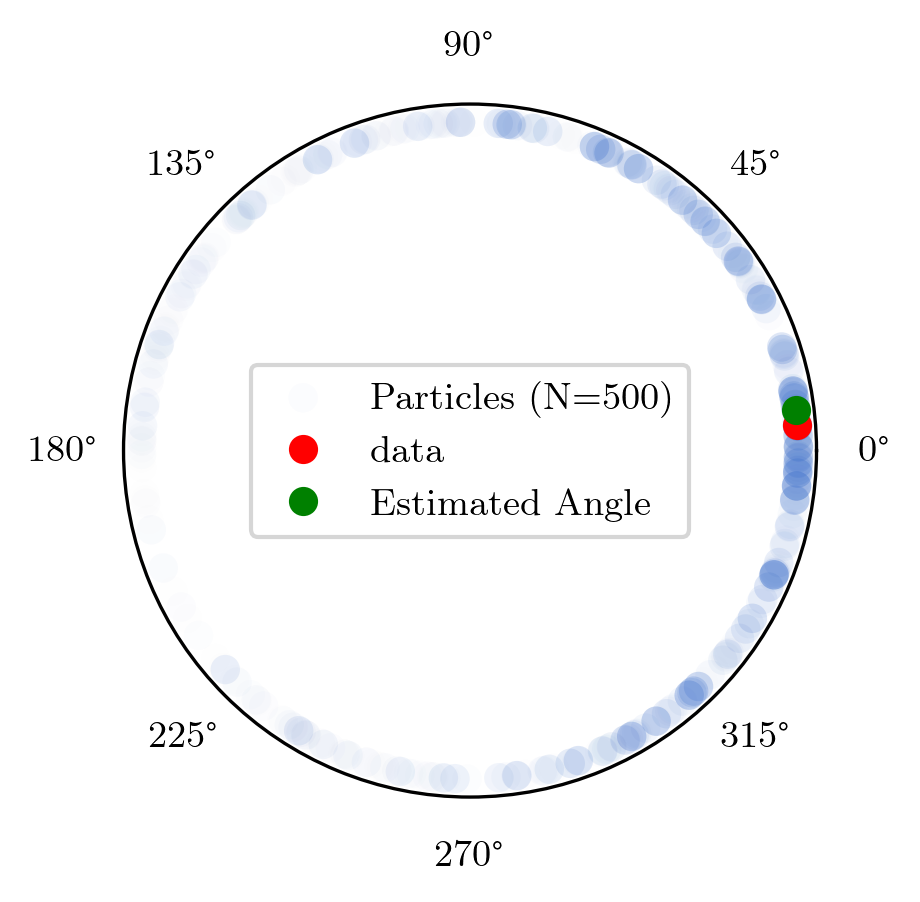

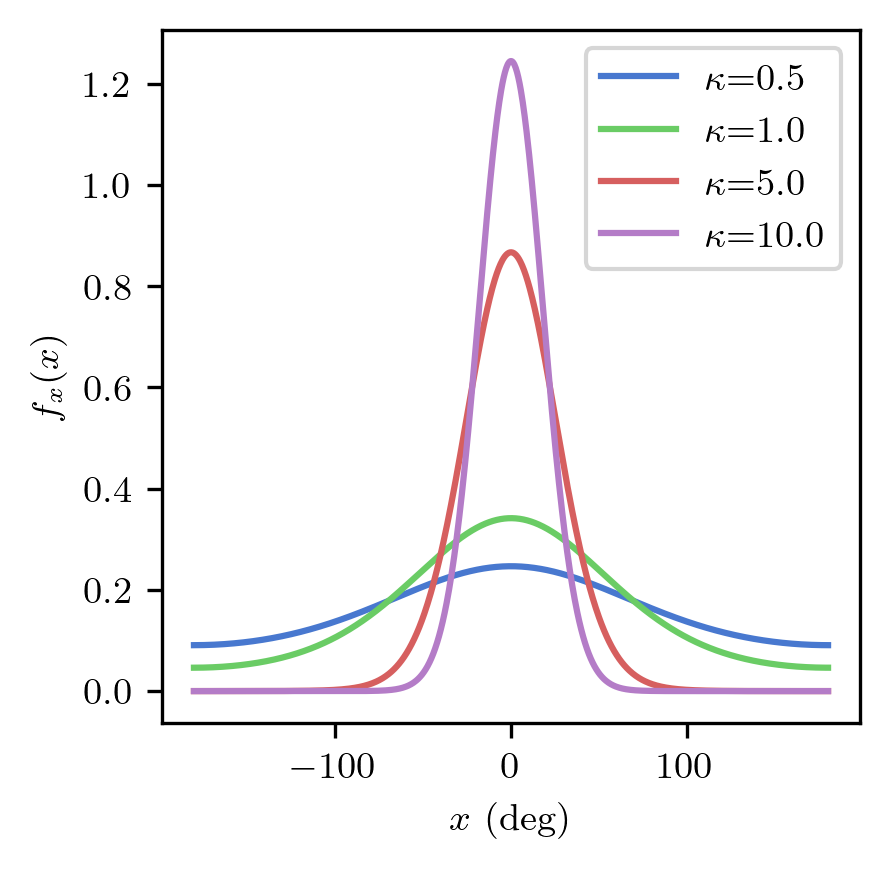

In [26]:
# ---------- Plot the Von Mises distribution, and the Particle Filter -----------

def plot_von_mises():
    """Show the Von Mises distribution."""
    angles = np.linspace(-np.pi,np.pi,1000)
    loc = 0
    kappas = np.array([.5,1,5,10])
    plt.figure(figsize=(3,3))
    for kap in kappas:
        von_m = vonmises.pdf(loc,kap,angles)
        plt.plot(np.rad2deg(angles),von_m,label = rf"$\kappa$={kap}")
    plt.gca().set(xlabel=r"$x$ (deg)", ylabel=r"$f_x(x)$")
    plt.legend()
    plt.savefig("actual_paper_graphs/von_mises_pdf.pdf", bbox_inches='tight', pad_inches=0)
    plt.show()


def plot_particles(index, obs,states):
    """
    Runs a particle filter on obs, plots the particles along with state estimate, current data
    """
    K1 = 1
    K2 = 1
    N_particles = 500
    n_eff = 100
    states[0] = states[0]%(2*np.pi)


    p_filter = ParticleFilter(F,K1,K2,N_particles,n_eff)
    state_estimates,particles,neff_list = p_filter.run_filter_verbose(obs)
    state_estimates = state_estimates%(2*np.pi)
    
    weights = p_filter.weights

    fig, ax = plt.subplots(figsize=(3,3),subplot_kw={'projection': 'polar'})
    
    frame = -1
    part = particles[frame]
    part = part[:,0]
    n_part = len(part)
    ax.clear()
    #Plot all the particles at the current time step
    ax.scatter(part,np.ones_like(part), 50, alpha=(0.5*weights / np.max(weights))**1,label = f'Particles (N={N_particles})', edgecolors="none")
    ax.plot(states[0,frame], 1,'o', c="red", label ='data')  # Plot current angle
    ax.plot(state_estimates[frame],1,'o', c="green", label='Estimated Angle')
    # ax.set_title(f'Num part:{n_part}')

    ax.grid(False)
    ax.set_yticklabels([])
    # ax.set_xticklabels([])

    ax.legend(loc='center')
    plt.savefig("actual_paper_graphs/particle_filter_example.pdf", bbox_inches='tight', pad_inches=0)
    plt.show()
    
#Initialize Kalman Filter Params, generate data
Q = np.eye(3) * 0.001
R = np.eye(18) * 0.5 
u = np.zeros(3)
#Initialize state transition matrix and other params
deltat = 0.1
F = np.array([[1,0,deltat],
              [1,0,0],
              [deltat**-1, deltat**-1, 0]])
H = np.zeros((18,3))
H[:,0] = np.ones(18)
kf = KalmanFilter(F, R, u, True)
n_steps = 100
x0 = np.array([np.pi, np.pi, 0])
states, obs = kf.evolve(x0, n_steps, H, R, Q)

#Use the plotting functions
plot_particles(50,obs,states)
plot_von_mises()

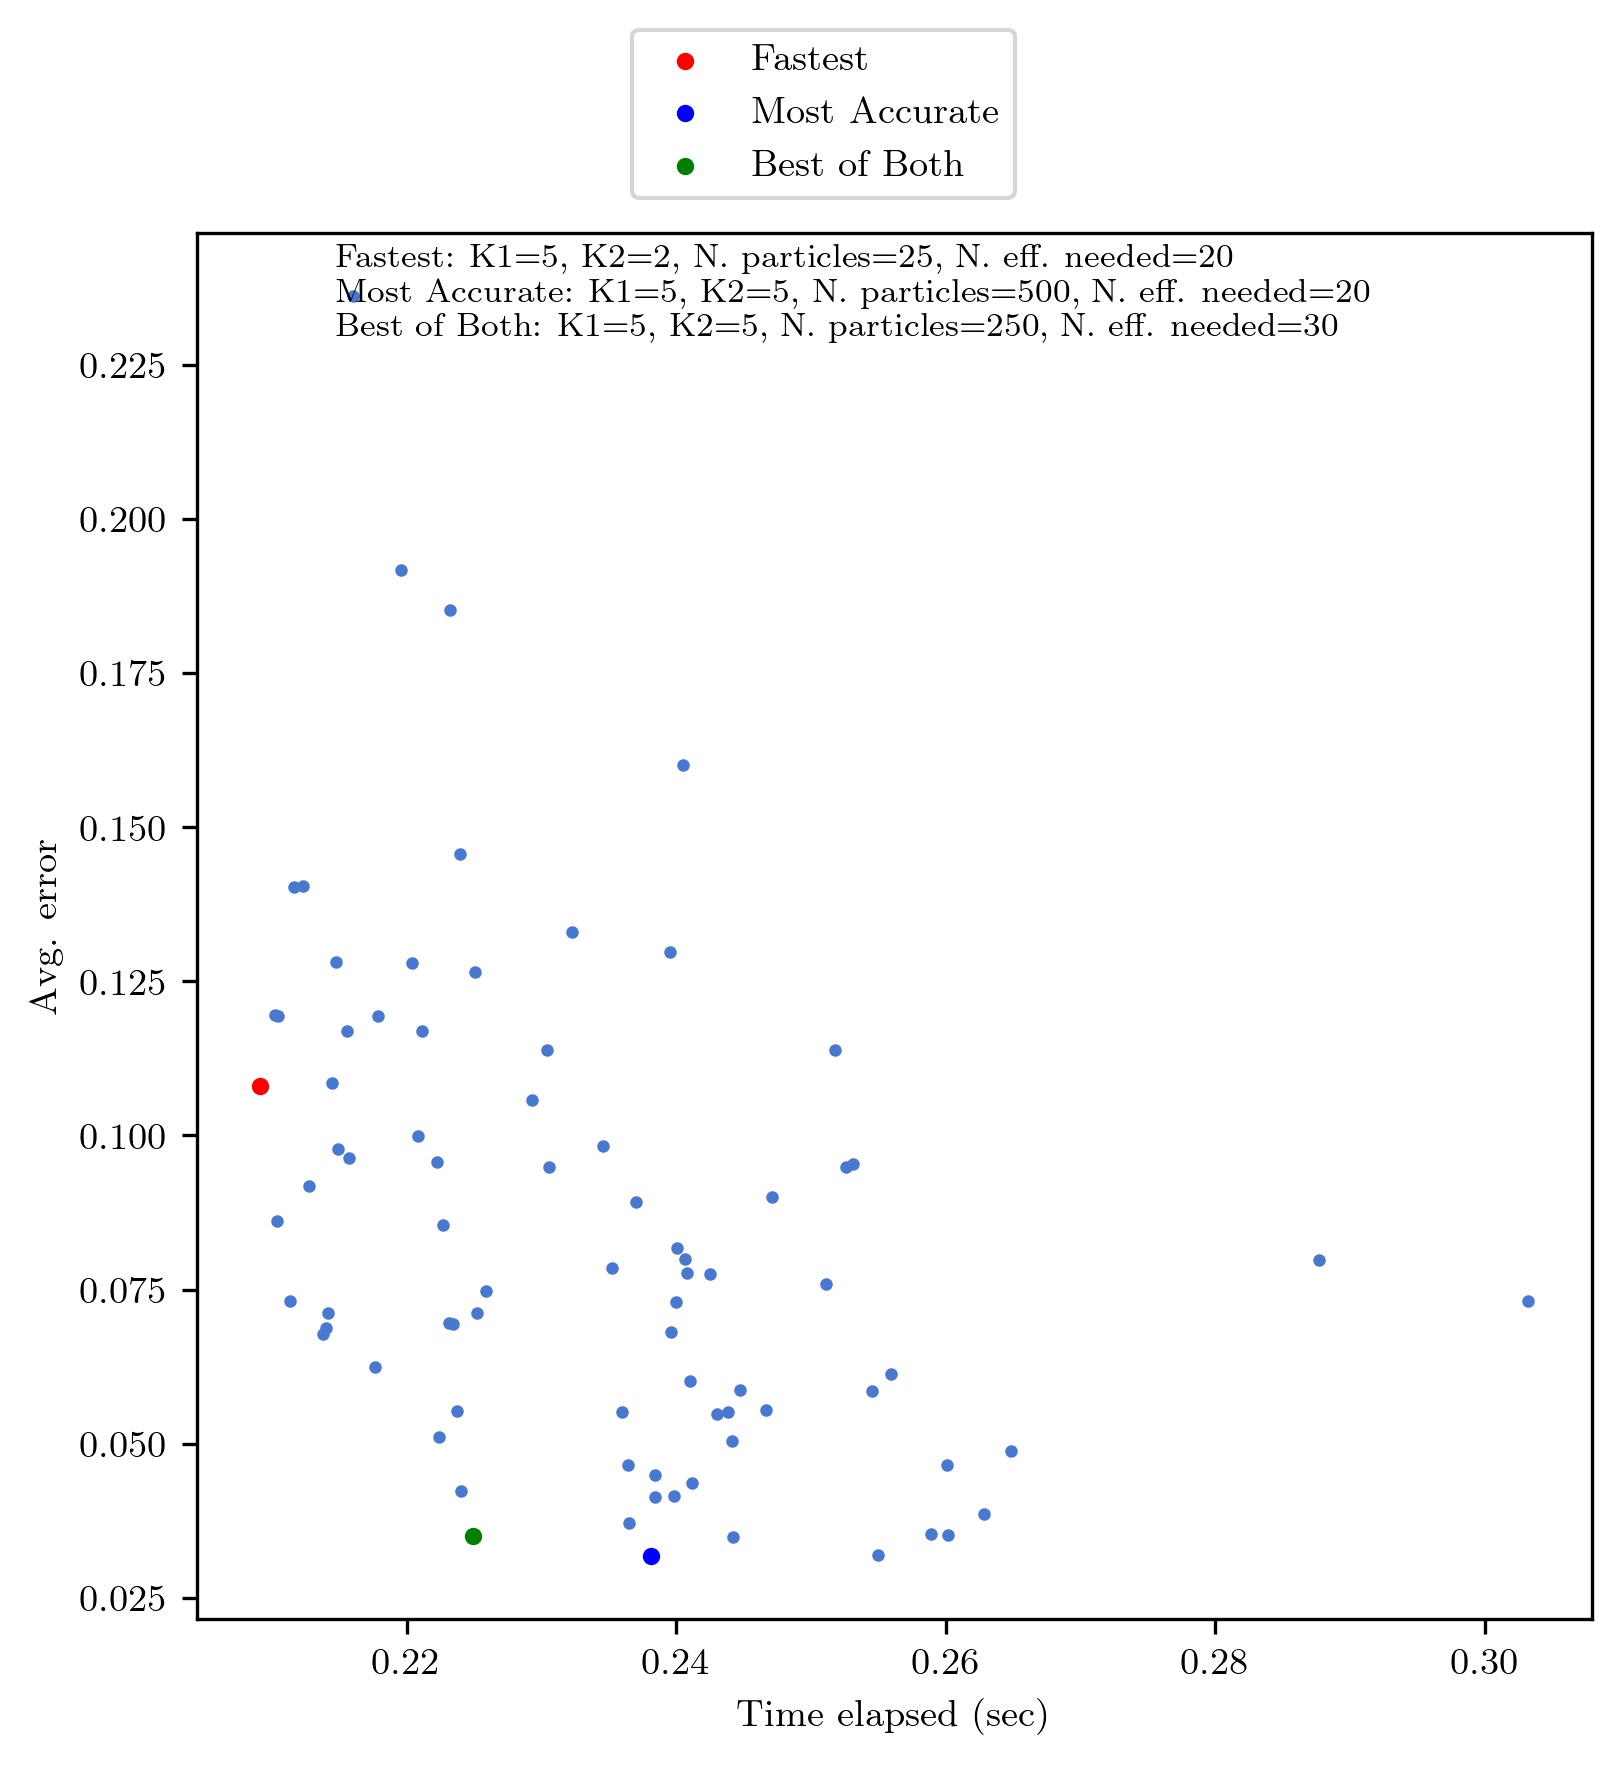

In [27]:
# --------- Perform a hyperparameter search on our particle filter -----------

def graph_hyperparam_search():
        

    ENGINE_DATA = read_data_csv("pinknoise_0_One_Angle.csv", "Pinknoise One Angle")
    ENGINE_DATA = (ENGINE_DATA[0][:,:200], ENGINE_DATA[1])
    deltat = 512./48000
    F = np.array([[1,0,deltat],
                [1,0,0],
                [deltat**-1, deltat**-1, 0]])
    #data is just one dimensional theta values
    theta_dim = 1
    H = np.zeros((theta_dim,3))
    H[:,0] = np.ones(theta_dim)
    u = np.zeros(3) #No control
    Q = np.eye(3) * 0.001
    R = np.eye(theta_dim) * 0.5 

    K1_vals = [1, 3, 5]
    K2_vals = [1, 2, 5]
    n_particles_vals = [25, 250, 500]
    n_eff_needed_vals = [10, 20, 30]
    dataset = ENGINE_DATA

    best_time_params = None
    best_score_params = None
    best_sum_params = None
    best_elapsed, best_error, best_sum = np.inf, np.inf, np.inf
    elapsed_vals, error_vals = [], []
    for K1, K2, N_particles, n_eff_needed in product(K1_vals, K2_vals, n_particles_vals, n_eff_needed_vals):
        pf = ParticleFilter(F, K1, K2, N_particles, n_eff_needed)
        elapsed, error = graph_filter(None, pf, ENGINE_DATA, ENGINE_DATA)
        elapsed_vals.append(elapsed)
        error_vals.append(error)
        
        if elapsed < best_elapsed:
            best_elapsed = elapsed
            best_time_params = (elapsed, error, K1, K2, N_particles, n_eff_needed)
        if error < best_error:
            best_error = error
            best_score_params = (elapsed, error, K1, K2, N_particles, n_eff_needed)
        if elapsed + error < best_sum:
            best_sum = elapsed + error
            best_sum_params = (elapsed, error, K1, K2, N_particles, n_eff_needed)
    

    plt.figure(figsize=(6,6,))
    
    plt.scatter(elapsed_vals, error_vals, 4)
    FS=8
    be_e, be_err, be_K1, be_K2, be_NP, be_NEN = best_time_params
    plt.scatter(be_e, be_err, s=10, c="red", label="Fastest")
    plt.text(0.1, 0.975, f"Fastest: K1={be_K1}, K2={be_K2}, N. particles={be_NP}, N. eff. needed={be_NEN}", fontsize=FS, transform=plt.gca().transAxes)

    be_e, be_err, be_K1, be_K2, be_NP, be_NEN = best_score_params
    plt.scatter(be_e, be_err, s=10, c="blue", label="Most Accurate")
    plt.text(0.1, 0.95, f"Most Accurate: K1={be_K1}, K2={be_K2}, N. particles={be_NP}, N. eff. needed={be_NEN}", fontsize=FS, transform=plt.gca().transAxes)

    be_e, be_err, be_K1, be_K2, be_NP, be_NEN = best_sum_params
    plt.scatter(be_e, be_err, s=10, c="green", label="Best of Both")
    plt.text(0.1, 0.925, f"Best of Both: K1={be_K1}, K2={be_K2}, N. particles={be_NP}, N. eff. needed={be_NEN}", fontsize=FS, transform=plt.gca().transAxes)

    plt.gca().set(xlabel="Time elapsed (sec)", ylabel="Avg. error")
    plt.legend(bbox_to_anchor=(0.6,1.16), bbox_transform=plt.gca().transAxes)
    plt.savefig("actual_paper_graphs/gridsearch_particle_filter.pdf", bbox_inches='tight', pad_inches=0)
    plt.show()
    # KalmanFilter(F, Q, H, R, u, True)
    
graph_hyperparam_search()

(18, 100)


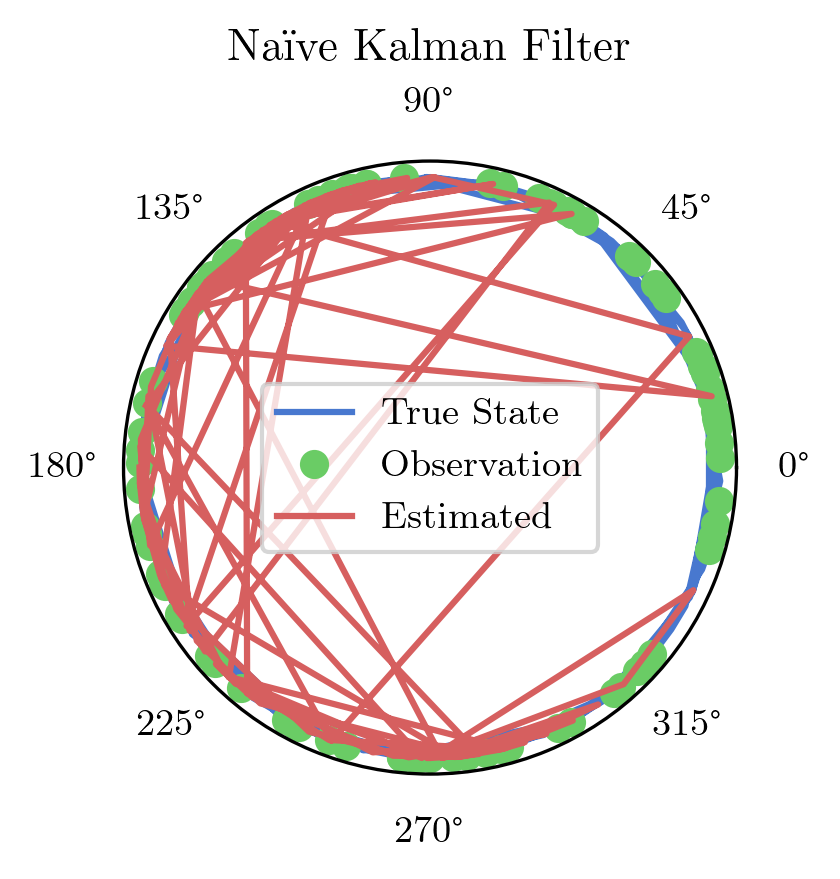

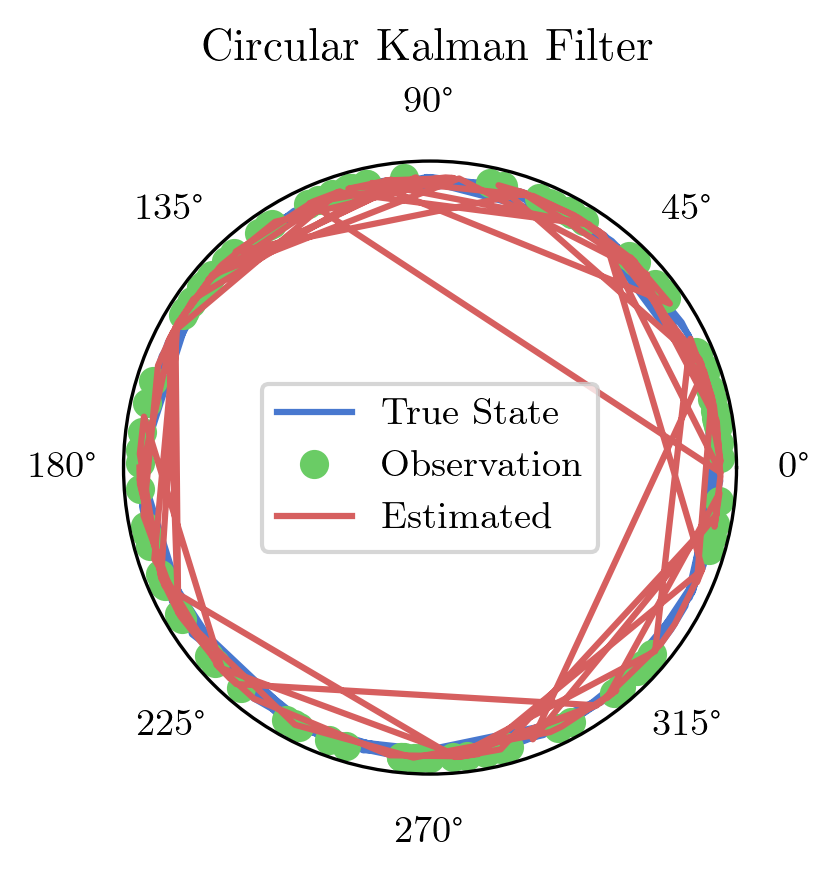

In [28]:
# ---------- Graph the Naive vs the Circular Kalman Filter ------------

def plot_kalman_method_explanations():
    deltat = 0.1
    F = np.array([[1,0,deltat],
                [1,0,0],
                [deltat**-1, deltat**-1, 0]])

    H = np.zeros((18,3))
    H[:,0] = np.ones(18)

    u = np.zeros(3)

    Q = np.eye(3) * 0.001
    R = np.eye(18) * 0.5 

    kf = KalmanFilter(F, Q, u, circular=False)

    x0 = np.array([np.pi, np.pi, 0])
    s, obs = kf.evolve(x0, 100, H, R, Q)

    print(obs.shape)

    kf_not_circ = KalmanFilter(F, Q, u, circular=False)
    kf_circ = KalmanFilter(F, Q, u, circular=True)

    est_b = kf_not_circ.estimate(np.array([np.pi, np.pi, 0]), np.eye(3)*0.001, obs[:,:])
    est_g = kf_circ.estimate(np.array([np.pi, np.pi, 0]), np.eye(3)*0.001, obs[:,:])
    
    # t = np.arange(100)
    # plt.figure(dpi=300)
    # plt.plot(s[0], label='State')
    # plt.plot(obs[0], 'o')
    # plt.plot(est_b[0], label='Est Plain old')
    # plt.plot(est_g[0], label='Est Circular')
    # plt.legend()
    # plt.show()



    fig, ax = plt.subplots(figsize=(3,3), subplot_kw={'projection':'polar'})
    # plt.figure(dpi=300, figsize=(10,5))
    ax.plot(s[0], np.ones_like(s[0]), label='True State')
    ax.plot(obs[0], np.ones_like(obs[0]), 'o', label='Observation')
    # plt.polar(est_g[0], np.ones_like(est_g[0]))
    ax.plot(est_b[0], np.ones_like(est_b[0]), label='Estimated')
    ax.set_title('Naïve Kalman Filter')
    # plt.tight_layout()
    ax.grid(False)
    ax.set_yticklabels([])
    ax.legend(loc='center')

    plt.tight_layout()
    plt.savefig('actual_paper_graphs/non_altered_kalman.pdf', dpi=300)
    plt.show()



    fig, ax = plt.subplots(figsize=(3,3), subplot_kw={'projection':'polar'})

    ax.plot(s[0], np.ones_like(s[0]), label='True State')
    ax.plot(obs[0], np.ones_like(obs[0]), 'o', label='Observation')
    ax.plot(est_g[0], np.ones_like(est_b[0]), label='Estimated')
    ax.set_title('Circular Kalman Filter')

    ax.grid(False)
    ax.set_yticklabels([])
    ax.legend(loc='center')
    plt.tight_layout()
    plt.savefig('actual_paper_graphs/altered_kalman.pdf', dpi=300)
    plt.show()

plot_kalman_method_explanations()